In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder import utils
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Graph parameters
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7
Gs['q'] = 0.015

# Signal parameters
K = 3
n_signals = 100
params = 4
n_p = 0.1

# Model parameters
fts = 150
epochs = 1000
lr = 0.001

JJ_samples = 1000

# Create graph
G = ds.create_graph(Gs, SEED)
A = G.W.todense()
plt.figure()
G.plot()

# Create filter H and decoder
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
H = x_dw.H
dec = GraphDecoder(fts, H)

# Compute Jacobians
start_time = time.time()
JJ_an = dec.analytical_squared_jacobian()
JJ_aut = dec.autograd_squared_jacobian()

# Expected Jacobians
Exp_JJ_an = np.zeros((G.N, G.N))
Exp_JJ_aut = np.zeros((G.N, G.N))
for i in range(JJ_samples):
    dec_aux = GraphDecoder(fts, H)
    Exp_JJ_an += dec_aux.analytical_squared_jacobian()
    Exp_JJ_aut += dec_aux.autograd_squared_jacobian()

Exp_JJ_an = Exp_JJ_an/JJ_samples
Exp_JJ_aut  = Exp_JJ_aut/JJ_samples

print('Jacobians done in {} minnutes'.format((time.time()-start_time)/60))

# Prepare signal models
Sig_mods = {}
Sig_mods['JJ_an'] = utils.ordered_eig(JJ_an)
Sig_mods['JJ_aut'] = utils.ordered_eig(JJ_aut)
Sig_mods['Exp_JJ_an'] = utils.ordered_eig(Exp_JJ_an)
Sig_mods['Exp_JJ_aut']  = utils.ordered_eig(Exp_JJ_aut)
Sig_mods['H'] = utils.ordered_eig(H)
Sig_mods['DW'] = None
Sig_mods['Rand'] = None
# Sig_mods['DW'] = None
print(Sig_mods.keys())

err = np.zeros((len(Sig_mods), n_signals, epochs, G.N))
err_wrt_n = np.zeros((len(Sig_mods), n_signals, epochs, G.N))
start_time = time.time()
for i in range(n_signals):
    for j, key in enumerate(Sig_mods.keys()):
        if key is 'Rand':
            x = np.random.randn(G.N)
            x /= np.linalg.norm(x)
        elif key is 'DW':
            x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.MEDIAN, K, coefs=hs)
            x_dw.to_unit_norm()
            x = x_dw.x
        else:
            Lambdas, V = Sig_mods[key]
            x = ds.bandlimited_signal( Lambdas, V, params) 

        x_n = ds.GraphSignal.add_noise(x, n_p)
        model = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
        err_wrt_n[j, i, :, :], err[j, i, :, :], _ = model.fit(x_n, x, reduce_err=False)

    print('Signal', i, 'done')

print('--- {} minutes ---'.format((time.time()-start_time)/60))

Filter coefs: [0.29399155 0.38311672 0.32289173]
Jacobians done in 0.5156145493189493 minnutes
dict_keys(['JJ_an', 'JJ_aut', 'Exp_JJ_an', 'Exp_JJ_aut', 'H', 'DW', 'Rand'])
Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done
Signal 50 done
Signal 51 done
Signal 52 done
Signal 53 done
Signal 54 done
Signal 55 don

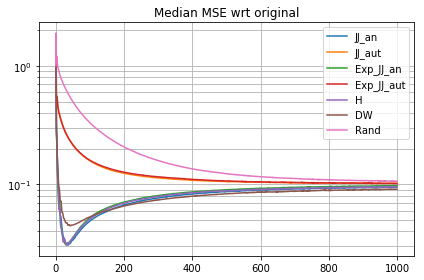

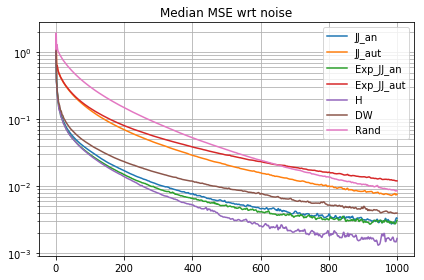

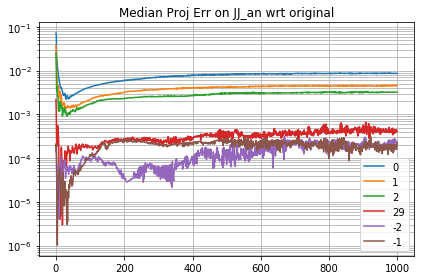

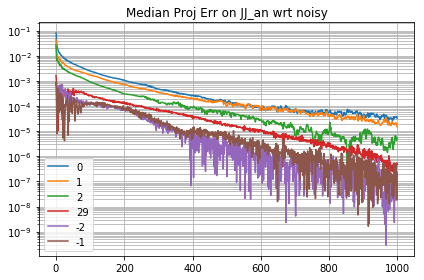

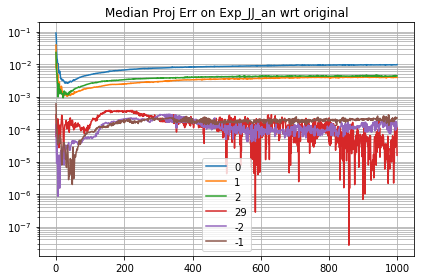

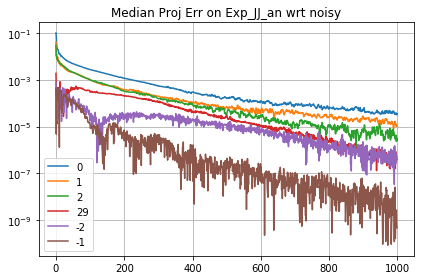

In [2]:
# Plots Median Error
med_mse = np.mean(np.sum(err, axis=3), axis=1)
plt.figure()
plt.semilogy(med_mse.T)
plt.grid(True, which='both')
plt.legend(Sig_mods.keys())
plt.title('Median MSE wrt original')
plt.tight_layout()

med_mse_n = np.mean(np.sum(err_wrt_n, axis=3), axis=1)
plt.figure()
plt.semilogy(med_mse_n.T)
plt.grid(True, which='both')
plt.legend(Sig_mods.keys())
plt.title('Median MSE wrt noise')
plt.tight_layout()

# Plot Projected Errors
ind = np.array([0, 1, 2, 29, -2, -1])

## On JJ_an
key_ind = list(Sig_mods.keys()).index('JJ_an')
V_ind = Sig_mods['JJ_an'][1][:, ind]
proj_err = np.median(err[key_ind, :, :, :].dot(V_ind), axis=0)
plt.figure()
plt.semilogy(np.abs(proj_err))
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Proj Err on JJ_an wrt original')
plt.tight_layout()

proj_err_n = np.median(err_wrt_n[key_ind, :, :, :].dot(V_ind), axis=0)
plt.figure()
plt.semilogy(np.abs(proj_err_n))
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Proj Err on JJ_an wrt noisy')
plt.tight_layout()

## On Exp_JJ_an
key_ind = list(Sig_mods.keys()).index('Exp_JJ_an')
V_ind = Sig_mods['Exp_JJ_an'][1][:, ind]

proj_err = np.median(err[key_ind, :, :, :].dot(V_ind), axis=0)
plt.figure()
plt.semilogy(np.abs(proj_err))
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Proj Err on Exp_JJ_an wrt original')
plt.tight_layout()

proj_err_n = np.median(err_wrt_n[key_ind, :, :, :].dot(V_ind), axis=0)
plt.figure()
plt.semilogy(np.abs(proj_err_n))
plt.legend(ind)
plt.grid(True, which='both')
plt.title('Median Proj Err on Exp_JJ_an wrt noisy')
plt.tight_layout()

Posibles experimentos:
- Probar distintos filtros: distinto numero de coeficientes y distintos tipos de coeficientes (probados a mano)
- Probar a hacerlo más profundo (?)
- Distintos tipos de "ruido", poniendo ruido solo en componentes de algunos autovectores

In [3]:
plt.show()